# Multiscale Metric Learning

MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are  8×88×8  pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64 dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of images.

To replicate Cuturi we need to run the metric learning algorithm using his approach. But that doesn't mean we can't run it on this 8x8 Reduced MNIST dataset as well. Approach is to perform PCA on the reduced dataset and then apply Cuturi's algorithm for learning the metric. We'll use as an initializer the PCA reduced learned metric for the original problem that is non PCA. 8x8 should be small enough to work. Will also implement it using both linear programming and Sinkhorn for determining the Wasserstein distances. 

8x8 means 64 dimensions. You can see from the analysis done that it's enough to have half of them to explain 95% of variance. This is the perfect scenario for CUTURI. 

In [1]:
from __future__ import print_function, division
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
# Your code goes here
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, Normalizer

import metric_learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors.ball_tree import BallTree
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Shogun - Metric Learning
from shogun import LMNN as shogun_LMNN
from shogun import RealFeatures, MulticlassLabels
from sklearn.utils.validation import check_X_y, check_array

# POT imports
import ot
from ot.datasets import get_1D_gauss as gauss

# Testing
from numpy import testing
from timeit import default_timer as timer


data_path = str(Path(os.getcwd())) + "/data/"
knn_path = str(Path(os.getcwd())) + "/data/knn_data/"
results_path = str(Path(os.getcwd())) + "/results/multiclass/"
results_lmnn = str(Path(os.getcwd())) + "/results/lmnn/"

def write_to_pickle(dataframe, name):
    dataframe.to_pickle(data_path + name + ".pickle")
def read_from_pickle(name): 
    return pd.read_pickle(data_path + name + ".pickle")

In [2]:
import mml 

In [3]:
# By default train LMNN with k = 3 
def train_lmnn(X_train, X_test, Y_train, init_transform, k=3, steps=1000, threshold=0.001, reg=0.5, learning_rate=1e-6):
    '''
    Trains an LMNN metric learning on data X_train and labels Y_train. 
    Transforms X train and test using the learned metric. 
    Uses init_transform as an initializer for LMNN, default np.eye(d,d)
    unless otherwise specified
    
    Returns: Transformed X train and test together with the learned metric, i.e. 
    [X_train_lmnn, X_test_lmnn, lmnn.metric]
    '''
    X_, y_ = check_X_y(X_train,Y_train,dtype=float)
    features = RealFeatures(X_.T)
    labels = MulticlassLabels(y_.astype(float))

    lmnn = shogun_LMNN(features,labels,k)
    
    lmnn.set_maxiter(steps)
    lmnn.set_obj_threshold(threshold)
    lmnn.set_regularization(reg)
    lmnn.set_stepsize(learning_rate)

    # Below is for pullback only!! 
    #initial_metric = pullback_metric
    #lmnn_shogun.train(initial_metric)
    lmnn.train(init_transform)

    # Metric transformation
    lmnn_transform = lmnn.get_linear_transform()

    # Transform the input space 
    X_train_lmnn = np.dot(X_train,lmnn_transform.T)
    X_test_lmnn = np.dot(X_test,lmnn_transform.T)
    
    return [X_train_lmnn, X_test_lmnn, lmnn]

Cell below - not used now

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
# Hellinger representation is sqrt of the data, try with normal representation too. 
X = np.sqrt(digits.data)
Y = digits.target
#X_train,X_test,Y_train, Y_test = train_test_split(X,Y,train_size=0.8,test_size=0.2,random_state=0)

In [4]:
# Original data normalized
X_train_normalized = np.load(knn_path + "X_train_normalized.npy")
X_test_normalized = np.load(knn_path + "X_test_normalized.npy")
#X_train_pca_normalized = np.load(knn_path + "X_train_normalizedpca.npy")
#X_test_pca_normalized = np.load(knn_path + "X_test_normalizedpca.npy")

# Original label data
Y_train = np.load(knn_path+"Y_train.npy")
Y_test = np.load(knn_path+"Y_test.npy")


# VAE
Y_train_vae = np.load(knn_path+"Y_train_vae.npy")
Y_test_vae = np.load(knn_path+"Y_test_vae.npy")

# VAE normalized
X_train_vae_normalized = np.load(knn_path + "X_train_normalized_vae.npy")
X_test_vae_normalized = np.load(knn_path + "X_test_normalized_vae.npy")


# PCA 
X_train_pca = np.load(data_path + "X_train_pca.npy")
X_test_pca = np.load(data_path + "X_test_pca.npy")

# PCA normalized
X_train_pca_normalized = np.load(knn_path + "X_train_normalized_pca_1.npy")
X_test_pca_normalized = np.load(knn_path + "X_test_normalized_pca_1.npy")

In [6]:
d = X_train_normalized.shape[1]
#x = np.arange(d,dtype=np.float64)
#x1 = x.reshape((d,1))
# By default metric ='sqeuclidean' in the function
#M_original = ot.dist(x1,x1,metric='euclidean')
#M_original_eye = ot.dist(x1,x1,metric='hamming')

# Replace first line with line below 
# M_gml = np.load(results_path+"gml_mnist_sift.npy")
M_gml = np.load(results_path+"gml30samples.npy")
M_gml_vae = np.load(results_path+"gml_mnist_vae.npy")
M_gml_pca = np.load(results_path+"gml_mnist_sift_pca.npy")

In [7]:
M_gml_sift = np.load(results_path + "gml_mnist_sift.npy")
M_gml_pca_1 = np.load(results_path+"gml_mnist_sift_pca_1.npy")

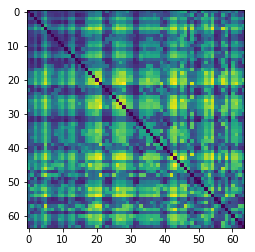

In [8]:
plt.imshow(M_gml_sift);

## LMNN Analysis

* LMNN (Shogun ML) on the original space. 
* A lot faster than the standard LMNN due to C++ interface
    1. Same method will be used when learning via the pullback as initializer
    2. Time it on the original space, time it on latent space, time it with pullback initializer. 
    3. Run it on a grid of values for k to see how accuracies & errors change, store only the highest values

In [9]:
K = [1,3,5,7,9,11]
col_names = ['K1','K3','K5','K7','K9','K11']

In [10]:
init_transform = np.eye(d,d)
datasets_lmnn_train = []
datasets_lmnn_test = []
# time it for every k 
T_default = []
transforms = []
for k in K: 
    # Dataset
    t_zero = timer()
    X_train_lmnn, X_test_lmnn, lmnn  = train_lmnn(X_train_normalized, X_test_normalized,Y_train,init_transform,k=k)
    t_after = timer()
    delta = t_after - t_zero
    print("Time elapsed for K=%d: %.2f s" %(k,delta))
    T_default.append(delta)

    # Metric transformations 
    lmnn_transform = lmnn.get_linear_transform()
    transforms.append(lmnn_transform)
    datasets_lmnn_train.append(X_train_lmnn)
    datasets_lmnn_test.append(X_test_lmnn)

Time elapsed for K=1: 64.45 s
Time elapsed for K=3: 179.39 s
Time elapsed for K=5: 269.70 s
Time elapsed for K=7: 363.26 s
Time elapsed for K=9: 453.22 s
Time elapsed for K=11: 506.98 s


In [ ]:
# In case you want to store the dataframes of the LMNN transformations
lmnn_df = pd.DataFrame(X_train_lmnn)
lmnn_test_df = pd.DataFrame(X_test_lmnn)
write_to_pickle(lmnn_df,'mnist_lmnn_original_train')
write_to_pickle(lmnn_test_df,'mnist_lmnn_original_test')

### 1. $L_2$ KNN on LMNN for 6 different datasets (K datasets)
Store results in a dataframe

In [11]:
df_accuracies_L2LMNN= pd.DataFrame(columns=col_names)
df_accuracies_L2LMNN.fillna(0)

df_errors_L2LMNN = pd.DataFrame(columns=col_names)
df_errors_L2LMNN.fillna(0)

for i in range(0,len(datasets_lmnn_train)): 
    accuracies_lmnn = []
    errors_lmnn = []
    for k in K:
        # build a model
        model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
        X_train_lmnn = datasets_lmnn_train[i]
        X_test_lmnn = datasets_lmnn_test[i]
        
        model.fit(X_train_lmnn,Y_train)

        # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
        score = model.score(X_test_lmnn, Y_test)
        prediction = model.predict_proba(X_test_lmnn)
        #error = getXEntropySoftmaxError(prediction, Y_test)
        error= log_loss(Y_test,prediction)

        print("K=%d, k=%d, accuracy=%.2f%%" % (i*2+1,k, score * 100))
        accuracies_lmnn.append(score)
        errors_lmnn.append(error)

    j = np.argmax(accuracies_lmnn)
    print("K=%d, k=%d achieved highest accuracy of %.2f%% on test data" % (i*2+1,K[j],
    accuracies_lmnn[i] * 100))
    # Store all results in dataframe
    df_accuracies_L2LMNN[col_names[i]] = accuracies_lmnn 
    df_errors_L2LMNN[col_names[i]] = errors_lmnn
    

K=1, k=1, accuracy=93.62%
K=1, k=3, accuracy=94.14%
K=1, k=5, accuracy=93.77%
K=1, k=7, accuracy=93.40%
K=1, k=9, accuracy=93.25%
K=1, k=11, accuracy=92.88%
K=1, k=3 achieved highest accuracy of 93.62% on test data
K=3, k=1, accuracy=95.92%
K=3, k=3, accuracy=96.36%
K=3, k=5, accuracy=96.51%
K=3, k=7, accuracy=96.74%
K=3, k=9, accuracy=96.07%
K=3, k=11, accuracy=95.18%
K=3, k=7 achieved highest accuracy of 96.36% on test data
K=5, k=1, accuracy=96.74%
K=5, k=3, accuracy=97.33%
K=5, k=5, accuracy=97.11%
K=5, k=7, accuracy=96.66%
K=5, k=9, accuracy=96.44%
K=5, k=11, accuracy=96.51%
K=5, k=3 achieved highest accuracy of 97.11% on test data
K=7, k=1, accuracy=96.51%
K=7, k=3, accuracy=97.11%
K=7, k=5, accuracy=96.81%
K=7, k=7, accuracy=96.81%
K=7, k=9, accuracy=96.59%
K=7, k=11, accuracy=96.51%
K=7, k=3 achieved highest accuracy of 96.81% on test data
K=9, k=1, accuracy=96.36%
K=9, k=3, accuracy=96.81%
K=9, k=5, accuracy=96.59%
K=9, k=7, accuracy=96.59%
K=9, k=9, accuracy=96.51%
K=9, k=11,

In [12]:
# Highest accuracy is for LMNN with 5 neighbours with KNN-3
df_accuracies_L2LMNN

,K1,K3,K5,K7,K9,K11
0,0.936202,0.959199,0.967359,0.965134,0.963650,0.959941
1,0.941395,0.963650,0.973294,0.971068,0.968101,0.962908
2,0.937685,0.965134,0.971068,0.968101,0.965875,0.962908
3,0.933976,0.967359,0.966617,0.968101,0.965875,0.960682
4,0.932493,0.960682,0.964392,0.965875,0.965134,0.959199
5,0.928783,0.951780,0.965134,0.965134,0.960682,0.958457


In [ ]:
# When running these change names to reflect experiments
df_accuracies_L2LMNN.to_pickle(results_lmnn + "L2_LMNN_Accuracies.pickle")
df_errors_L2LMNN.to_pickle(results_lmnn + "L2_LMNN_Errors.pickle")

### 2. $L_2$ KNN on PCA LMNN 
Store results in dataframe

In [13]:
X_train_pca.shape

(449, 36)

In [14]:
# Apply LMNN to PCA data
lower_d = 36
init_transform = np.eye(lower_d,lower_d)
datasets_lmnn_train_pca = []
datasets_lmnn_test_pca = []
# time it for every k 
T_default_pca = []
transforms_pca = []
for k in K: 
    # Dataset
    t_zero = timer()
    X_train_pca_lmnn, X_test_pca_lmnn, lmnn_pca = train_lmnn(X_train_pca,X_test_pca,Y_train,init_transform,k=k)
    t_after = timer()
    delta = t_after - t_zero
    print("Time elapsed for K=%d: %.2f s" %(k,delta))
    T_default_pca.append(delta)

    # Metric transformations 
    lmnn_transform = lmnn_pca.get_linear_transform()
    transforms_pca.append(lmnn_transform)
    datasets_lmnn_train_pca.append(X_train_pca_lmnn)
    datasets_lmnn_test_pca.append(X_test_pca_lmnn)

Time elapsed for K=1: 54.84 s
Time elapsed for K=3: 163.58 s
Time elapsed for K=5: 252.51 s
Time elapsed for K=7: 340.79 s
Time elapsed for K=9: 417.33 s
Time elapsed for K=11: 490.15 s


In [15]:
# Create dataframe to hold results
df_accuracies_L2LMNN_PCA= pd.DataFrame(columns=col_names)
df_accuracies_L2LMNN_PCA.fillna(0)

df_errors_L2LMNN_PCA = pd.DataFrame(columns=col_names)
df_errors_L2LMNN_PCA.fillna(0)

# Train KNN for all datasets for K different values
for i in range(0,len(datasets_lmnn_train_pca)): 
    accuracies_lmnn = []
    errors_lmnn = []
    for k in K:
        # build a model
        model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
        X_train_lmnn = datasets_lmnn_train_pca[i]
        X_test_lmnn = datasets_lmnn_test_pca[i]
        
        model.fit(X_train_lmnn,Y_train)

        # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
        score = model.score(X_test_lmnn, Y_test)
        prediction = model.predict_proba(X_test_lmnn)
        #error = getXEntropySoftmaxError(prediction, Y_test)
        error= log_loss(Y_test,prediction)

        print("K=%d, k=%d, accuracy=%.2f%%" % (i*2+1,k, score * 100))
        accuracies_lmnn.append(score)
        errors_lmnn.append(error)

    j = np.argmax(accuracies_lmnn)
    print("K=%d, k=%d achieved highest accuracy of %.2f%% on test data" % (i*2+1,K[j],
    accuracies_lmnn[i] * 100))
    # Store all results in dataframe
    df_accuracies_L2LMNN_PCA[col_names[i]] = accuracies_lmnn 
    df_errors_L2LMNN_PCA[col_names[i]] = errors_lmnn

K=1, k=1, accuracy=93.47%
K=1, k=3, accuracy=94.58%
K=1, k=5, accuracy=93.47%
K=1, k=7, accuracy=93.84%
K=1, k=9, accuracy=93.32%
K=1, k=11, accuracy=93.10%
K=1, k=3 achieved highest accuracy of 93.47% on test data
K=3, k=1, accuracy=95.92%
K=3, k=3, accuracy=96.36%
K=3, k=5, accuracy=96.51%
K=3, k=7, accuracy=96.36%
K=3, k=9, accuracy=95.85%
K=3, k=11, accuracy=95.25%
K=3, k=5 achieved highest accuracy of 96.36% on test data
K=5, k=1, accuracy=96.36%
K=5, k=3, accuracy=97.11%
K=5, k=5, accuracy=97.26%
K=5, k=7, accuracy=96.66%
K=5, k=9, accuracy=96.66%
K=5, k=11, accuracy=96.44%
K=5, k=5 achieved highest accuracy of 97.26% on test data
K=7, k=1, accuracy=96.51%
K=7, k=3, accuracy=97.03%
K=7, k=5, accuracy=96.88%
K=7, k=7, accuracy=96.88%
K=7, k=9, accuracy=96.59%
K=7, k=11, accuracy=96.59%
K=7, k=3 achieved highest accuracy of 96.88% on test data
K=9, k=1, accuracy=96.66%
K=9, k=3, accuracy=96.66%
K=9, k=5, accuracy=96.74%
K=9, k=7, accuracy=96.96%
K=9, k=9, accuracy=96.81%
K=9, k=11,

In [16]:
df_accuracies_L2LMNN_PCA

,K1,K3,K5,K7,K9,K11
0,0.934718,0.959199,0.963650,0.965134,0.966617,0.967359
1,0.945846,0.963650,0.971068,0.970326,0.966617,0.968101
2,0.934718,0.965134,0.972552,0.968843,0.967359,0.970326
3,0.938427,0.963650,0.966617,0.968843,0.969585,0.968101
4,0.933234,0.958457,0.966617,0.965875,0.968101,0.966617
5,0.931009,0.952522,0.964392,0.965875,0.962908,0.964392


In [ ]:
# Run only if you are changing experiments somehow
df_accuracies_L2LMNN_PCA.to_pickle(results_lmnn + "L2_LMNN_Accuracies_PCA.pickle")
df_errors_L2LMNN_PCA.to_pickle(results_lmnn + "L2_LMNN_Errors_PCA.pickle")

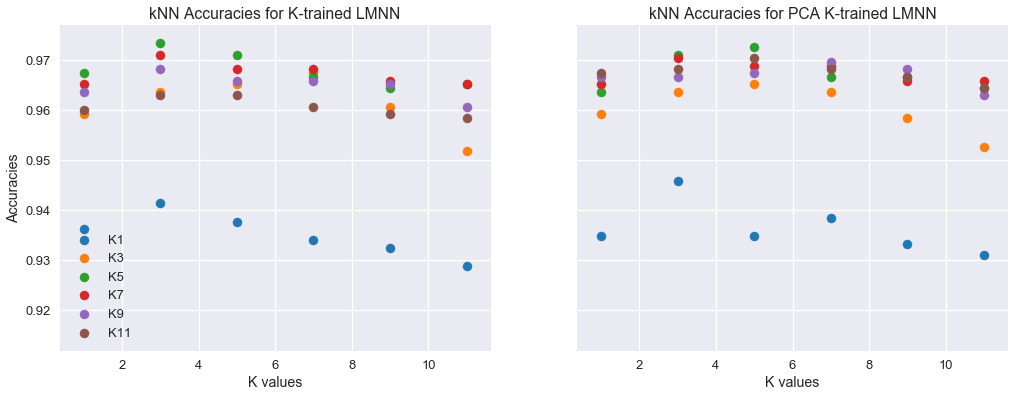

In [17]:
pl.style.use('seaborn-darkgrid')
sns.set_context("talk")
fig, ax = pl.subplots(1,2,sharey=True,figsize = (17,6))

for col in df_accuracies_L2LMNN.columns:
    color = np.random.randint(low=1, high=10 * 10)
    ax[0].scatter(K,df_accuracies_L2LMNN[col])
    ax[0].set_title("kNN Accuracies for K-trained LMNN")
    ax[0].set_xlabel("K values")
    ax[0].set_ylabel("Accuracies")
    ax[0].legend(loc=3)
for col in df_accuracies_L2LMNN_PCA.columns:
    color = np.random.randint(low=1, high=10 * 10)
    ax[1].scatter(K,df_accuracies_L2LMNN_PCA[col])
    ax[1].set_title("kNN Accuracies for PCA K-trained LMNN")
    ax[1].set_xlabel("K values")
    
fig.savefig(results_lmnn + "L2_LMNN_Accuracies.png")    

In [18]:
df_T_default = pd.DataFrame(T_default)
df_T_default_pca = pd.DataFrame(T_default_pca)

df_T_default.to_pickle(results_lmnn + "L2_LMNN_Train_time.pickle")
df_T_default_pca.to_pickle(results_lmnn + "L2_LMNN_PCA_Train_time.pickle")

In [19]:
df_T_default

,0
0,64.453080
1,179.390063
2,269.703305
3,363.259518
4,453.220329
5,506.977149


### 3. $L_2$ KNN on Pullback LMNN PCA 

Pullback of PCA metric through the inverse transformation to reach the dimension of the upper metric

In [20]:
P = np.load(data_path + "PCA_Components.npy")
lmnn_pullbacks = []
lmnn_pullback_metrics = []
for linear_transform in transforms_pca: 
    L_pca = linear_transform
    pullback = np.dot(P.T,np.dot(L_pca,P))
    lmnn_pullbacks.append(pullback)
    
    M_pca = np.dot(L_pca,L_pca.T)
    pullback_1 = np.dot(P.T,np.dot(M_pca,P))
    lmnn_pullback_metrics.append(pullback_1)

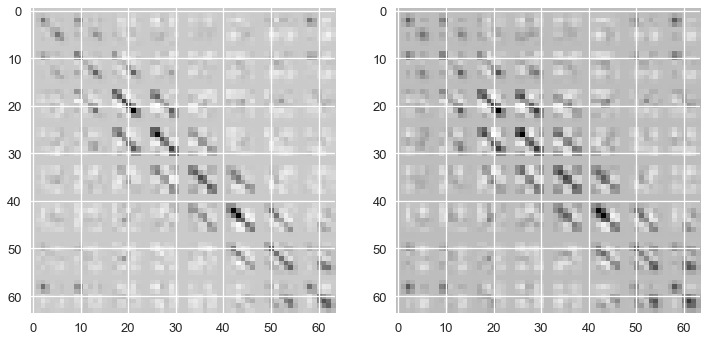

In [21]:
# Visualize first pullback as an example
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(lmnn_pullbacks[0])
ax[1].imshow(lmnn_pullback_metrics[0]);

i) first formula $P * L * P^T$

In [22]:
# Train LMNN using pullbacks as initializers and time it 
# Compare not only accuracies but time it took to train LMNN whilst initializing with pullback
# Below will give you times. 
datasets_lmnn_train_pullback_pca = []
datasets_lmnn_test_pullback_pca = []
# time it for every k 
T_default_pullback_pca = []
transforms_pullback_pca = []
for (i,k) in enumerate(K): 
    # Dataset
    t_zero = timer()
    X_train_lmnn, X_test_lmnn, lmnn  = train_lmnn(X_train_normalized, X_test_normalized,Y_train,lmnn_pullbacks[i],k=k)
    t_after = timer()
    delta = t_after - t_zero
    print("Time elapsed for K=%d: %.2f s" %(k,delta))
    T_default_pullback_pca.append(delta)

    # Metric transformations 
    lmnn_transform = lmnn.get_linear_transform()
    transforms_pullback_pca.append(lmnn_transform)
    datasets_lmnn_train_pullback_pca.append(X_train_lmnn)
    datasets_lmnn_test_pullback_pca.append(X_test_lmnn)

Time elapsed for K=1: 1.92 s
Time elapsed for K=3: 0.11 s
Time elapsed for K=5: 0.17 s
Time elapsed for K=7: 0.23 s
Time elapsed for K=9: 16.13 s
Time elapsed for K=11: 20.87 s


In [24]:
df_accuracies_L2LMNN_pullback= pd.DataFrame(columns=col_names)
df_accuracies_L2LMNN_pullback.fillna(0)

df_errors_L2LMNN_pullback = pd.DataFrame(columns=col_names)
df_errors_L2LMNN_pullback.fillna(0)

for i in range(0,len(datasets_lmnn_train_pullback_pca)): 
    accuracies_lmnn = []
    errors_lmnn = []
    for k in K:
        # build a model
        model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
        X_train_lmnn = datasets_lmnn_train_pullback_pca[i]
        X_test_lmnn = datasets_lmnn_test_pullback_pca[i]
        
        model.fit(X_train_lmnn,Y_train)

        # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
        score = model.score(X_test_lmnn, Y_test)
        prediction = model.predict_proba(X_test_lmnn)
        #error = getXEntropySoftmaxError(prediction, Y_test)
        error= log_loss(Y_test,prediction)

        print("K=%d, k=%d, accuracy=%.2f%%" % (i*2+1,k, score * 100))
        accuracies_lmnn.append(score)
        errors_lmnn.append(error)

    j = np.argmax(accuracies_lmnn)
    print("K=%d, k=%d achieved highest accuracy of %.2f%% on test data" % (i*2+1,K[j],
    accuracies_lmnn[i] * 100))
    # Store all results in dataframe
    df_accuracies_L2LMNN_pullback[col_names[i]] = accuracies_lmnn 
    df_errors_L2LMNN_pullback[col_names[i]] = errors_lmnn

K=1, k=1, accuracy=93.47%
K=1, k=3, accuracy=94.58%
K=1, k=5, accuracy=93.47%
K=1, k=7, accuracy=93.84%
K=1, k=9, accuracy=93.32%
K=1, k=11, accuracy=93.10%
K=1, k=3 achieved highest accuracy of 93.47% on test data
K=3, k=1, accuracy=95.92%
K=3, k=3, accuracy=96.36%
K=3, k=5, accuracy=96.51%
K=3, k=7, accuracy=96.36%
K=3, k=9, accuracy=95.85%
K=3, k=11, accuracy=95.25%
K=3, k=5 achieved highest accuracy of 96.36% on test data
K=5, k=1, accuracy=96.36%
K=5, k=3, accuracy=97.11%
K=5, k=5, accuracy=97.26%
K=5, k=7, accuracy=96.66%
K=5, k=9, accuracy=96.66%
K=5, k=11, accuracy=96.44%
K=5, k=5 achieved highest accuracy of 97.26% on test data
K=7, k=1, accuracy=96.51%
K=7, k=3, accuracy=97.03%
K=7, k=5, accuracy=96.88%
K=7, k=7, accuracy=96.88%
K=7, k=9, accuracy=96.59%
K=7, k=11, accuracy=96.59%
K=7, k=3 achieved highest accuracy of 96.88% on test data
K=9, k=1, accuracy=96.59%
K=9, k=3, accuracy=96.88%
K=9, k=5, accuracy=96.88%
K=9, k=7, accuracy=96.59%
K=9, k=9, accuracy=96.51%
K=9, k=11,

ii) second formula $P * L*L^T * P^T$

In [23]:
# Train LMNN using pullbacks as initializers and time it 
# Compare not only accuracies but time it took to train LMNN whilst initializing with pullback
# Below will give you times. 
datasets_lmnn_train_pullback_metrics_pca = []
datasets_lmnn_test_pullback_metrics_pca = []
# time it for every k 
T_default_pullback_pca = []
transforms_pullback_pca = []
for (i,k) in enumerate(K): 
    # Dataset
    t_zero = timer()
    X_train_lmnn, X_test_lmnn, lmnn  = train_lmnn(X_train_normalized, X_test_normalized,Y_train,lmnn_pullback_metrics[i],k=k)
    t_after = timer()
    delta = t_after - t_zero
    print("Time elapsed for K=%d: %.2f s" %(k,delta))
    T_default_pullback_pca.append(delta)

    # Metric transformations 
    lmnn_transform = lmnn.get_linear_transform()
    transforms_pullback_pca.append(lmnn_transform)
    datasets_lmnn_train_pullback_metrics_pca.append(X_train_lmnn)
    datasets_lmnn_test_pullback_metrics_pca.append(X_test_lmnn)

Time elapsed for K=1: 2.70 s
Time elapsed for K=3: 5.80 s
Time elapsed for K=5: 8.09 s
Time elapsed for K=7: 10.74 s
Time elapsed for K=9: 14.29 s
Time elapsed for K=11: 19.31 s


In [25]:
df_accuracies_L2LMNN_pullback_metrics= pd.DataFrame(columns=col_names)
df_accuracies_L2LMNN_pullback_metrics.fillna(0)

df_errors_L2LMNN_pullback_metrics = pd.DataFrame(columns=col_names)
df_errors_L2LMNN_pullback_metrics.fillna(0)

for i in range(0,len(datasets_lmnn_train_pullback_pca)): 
    accuracies_lmnn = []
    errors_lmnn = []
    for k in K:
        # build a model
        model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
        X_train_lmnn = datasets_lmnn_train_pullback_metrics_pca[i]
        X_test_lmnn = datasets_lmnn_test_pullback_metrics_pca[i]
        
        model.fit(X_train_lmnn,Y_train)

        # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
        score = model.score(X_test_lmnn, Y_test)
        prediction = model.predict_proba(X_test_lmnn)
        #error = getXEntropySoftmaxError(prediction, Y_test)
        error= log_loss(Y_test,prediction)

        print("K=%d, k=%d, accuracy=%.2f%%" % (i*2+1,k, score * 100))
        accuracies_lmnn.append(score)
        errors_lmnn.append(error)

    j = np.argmax(accuracies_lmnn)
    print("K=%d, k=%d achieved highest accuracy of %.2f%% on test data" % (i*2+1,K[j],
    accuracies_lmnn[i] * 100))
    # Store all results in dataframe
    df_accuracies_L2LMNN_pullback_metrics[col_names[i]] = accuracies_lmnn 
    df_errors_L2LMNN_pullback_metrics[col_names[i]] = errors_lmnn
    

K=1, k=1, accuracy=92.06%
K=1, k=3, accuracy=92.51%
K=1, k=5, accuracy=91.77%
K=1, k=7, accuracy=91.39%
K=1, k=9, accuracy=90.80%
K=1, k=11, accuracy=89.76%
K=1, k=3 achieved highest accuracy of 92.06% on test data
K=3, k=1, accuracy=95.85%
K=3, k=3, accuracy=96.29%
K=3, k=5, accuracy=96.07%
K=3, k=7, accuracy=95.99%
K=3, k=9, accuracy=94.88%
K=3, k=11, accuracy=94.14%
K=3, k=3 achieved highest accuracy of 96.29% on test data
K=5, k=1, accuracy=95.99%
K=5, k=3, accuracy=96.44%
K=5, k=5, accuracy=96.44%
K=5, k=7, accuracy=96.44%
K=5, k=9, accuracy=96.07%
K=5, k=11, accuracy=95.62%
K=5, k=3 achieved highest accuracy of 96.44% on test data
K=7, k=1, accuracy=95.99%
K=7, k=3, accuracy=96.51%
K=7, k=5, accuracy=96.59%
K=7, k=7, accuracy=96.36%
K=7, k=9, accuracy=96.59%
K=7, k=11, accuracy=96.44%
K=7, k=5 achieved highest accuracy of 96.36% on test data
K=9, k=1, accuracy=95.70%
K=9, k=3, accuracy=95.85%
K=9, k=5, accuracy=95.62%
K=9, k=7, accuracy=95.77%
K=9, k=9, accuracy=95.92%
K=9, k=11,

____!Look at the times!!!____

### Plot the LMNN pullback vs original accuracies

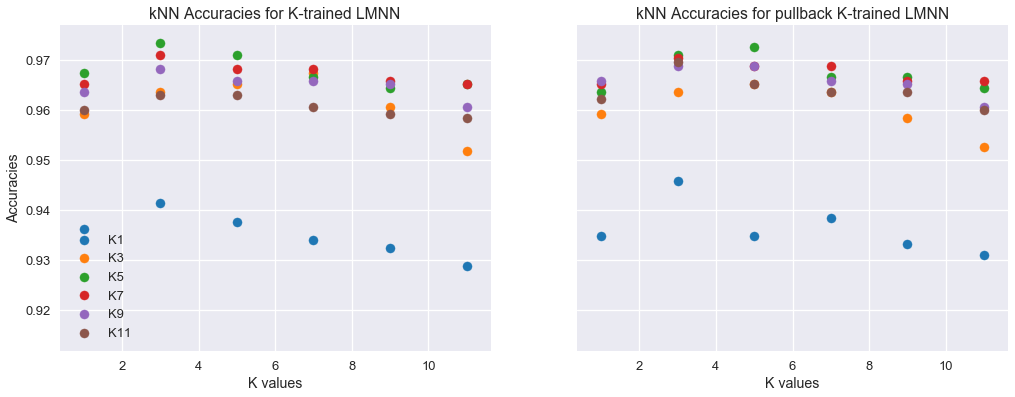

In [26]:
pl.style.use('seaborn-darkgrid')
sns.set_context("talk")
fig, ax = pl.subplots(1,2,sharey=True,figsize = (17,6))

for col in df_accuracies_L2LMNN.columns:
    color = np.random.randint(low=1, high=10 * 10)
    ax[0].scatter(K,df_accuracies_L2LMNN[col])
    ax[0].set_title("kNN Accuracies for K-trained LMNN")
    ax[0].set_xlabel("K values")
    ax[0].set_ylabel("Accuracies")
    ax[0].legend(loc=3)
for col in df_accuracies_L2LMNN_pullback.columns:
    color = np.random.randint(low=1, high=10 * 10)
    ax[1].scatter(K,df_accuracies_L2LMNN_pullback[col])
    ax[1].set_title("kNN Accuracies for pullback K-trained LMNN")
    ax[1].set_xlabel("K values")
    
fig.savefig(results_lmnn + "L2_LMNN_Pullback_Accuracies.png")    

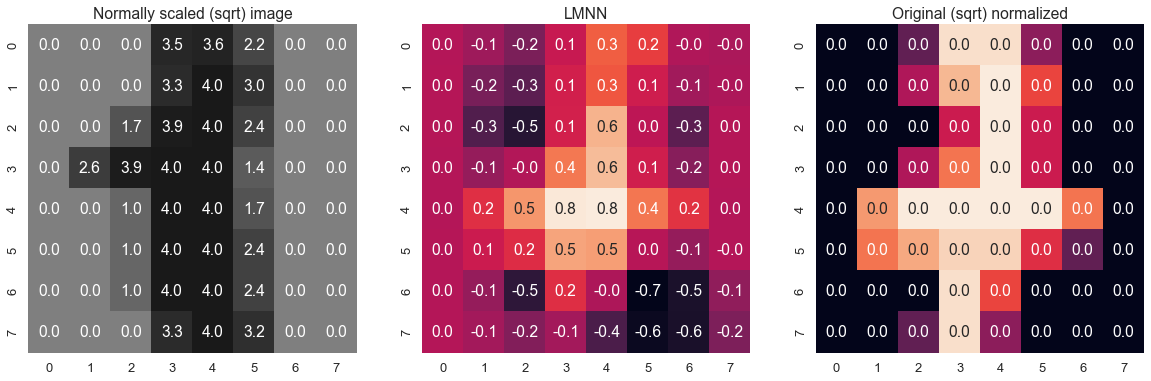

In [31]:
# A bit of visuals
fig, ax = plt.subplots(1,3, figsize=(20,12))

# Original image
sns.heatmap(X[1].reshape((8,8)), ax=ax[0], square=True, cmap = 'gray_r',cbar=False,
            annot=True, fmt='0.1f', vmin=-5, vmax=5)
ax[0].set_title('Normally scaled (sqrt) image')

# LMNN image
sns.heatmap(datasets_lmnn_train[1][1].reshape((8,8)), ax=ax[1], square=True, cbar=False,
            annot=True, fmt='0.1f')
ax[1].set_title('LMNN')

# Normalized
sns.heatmap(X_train_normalized[1].reshape((8,8)), ax=ax[2], square=True, cbar=False,
            annot=True, fmt='0.1f')
ax[2].set_title('Original (sqrt) normalized')

_ = plt.legend()

___

## Wasserstein Analysis
As opposed to LMNN we'll do the analysis with only one ground metric that was learned with k=3. GML is Ground Metric Learning. 

We're running the analysis only with K1 = [1,3,5] until I get Wasserstein to run faster or use Sinkhorn

In [32]:
K1 = [1,3,5]

### 4. $W_2$ KNN with GML
Equivalent to what Cuturi did 

In [40]:
# Transform into histogram since LMNN is non-normalized
# Wasserstein needs normalized data
#[X_train_normalized, X_test_normalized] = mml.transform.normalize(X_train,X_test,'l1')

# K Nearest Neighbour with predefined metric
# model_wasserstein = KNeighborsClassifier(n_neighbors=k,metric='pyfunc')
acc_wasserstein_l2 = []
errors_wasserstein_l2 = []
        
for k in K1:    
    model_l2_wasserstein = KNeighborsClassifier(n_neighbors=k,metric=mml.wasserstein.distance,\
                                                  metric_params={"ground metric":M_gml_sift})
    model_l2_wasserstein.fit(X_train_normalized,Y_train)
    
    score_w = model_l2_wasserstein.score(X_test_normalized,Y_test)
    prediction = model_l2_wasserstein.predict_proba(X_test_normalized)
    
    error = log_loss(Y_test,prediction)
    print("k=%d, accuracy=%.2f%%" % (k, score_w * 100))
    acc_wasserstein_l2.append(score_w)
    errors_wasserstein_l2.append(error)


j = np.argmax(acc_wasserstein_l2)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K1[j],
acc_wasserstein_l2[j] * 100))

k=1, accuracy=96.81%
k=3, accuracy=96.29%
k=5, accuracy=96.44%
k=1 achieved highest accuracy of 96.81% on test data


### 5. $W_2$ KNN with PCA GML 
**!RUN ME next!**

In [ ]:
# Add the maximum minimum value to each sample. Then normalize to histograms
#[X_train_pca_normalized,X_test_pca_normalized] = mml.transform.positive_and_normalize(X_train_pca,X_test_pca,'l1')

acc_knn_pca_wasserstein = []
errors_knn_pca_wasserstein = []

#d_pca = X_train_pca_normalized.shape[1]
#x_pca = np.arange(d_pca,dtype=np.float64)
#x1_pca = x_pca.reshape((d_pca,1))
# By default metric ='sqeuclidean' in the function
#ground_pca = ot.dist(x1_pca,x1_pca,metric='euclidean')


for k in K1:    
    pca_model_wasserstein = KNeighborsClassifier(n_neighbors=k,metric=mml.wasserstein.distance,\
                                                 metric_params={"ground metric":M_gml_pca_1})
    pca_model_wasserstein.fit(X_train_pca_normalized,Y_train)
    
    score_w = pca_model_wasserstein.score(X_test_pca_normalized,Y_test)
    prediction = pca_model_wasserstein.predict_proba(X_test_pca_normalized)
    
    error = log_loss(Y_test,prediction)
    print("k=%d, accuracy=%.2f%%" % (k, score_w * 100))
    
    acc_knn_pca_wasserstein.append(score_w)
    errors_knn_pca_wasserstein.append(error)

# find the value of k that has the largest accuracy
j = np.argmax(acc_knn_pca_wasserstein)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K1[j],
acc_knn_pca_wasserstein[j] * 100))

k=1, accuracy=92.95%
k=3, accuracy=92.66%


### 6.  $W_2$ KNN Pullback
    a) PCA Pullback acts as GML on original space
    b) PCA Pullback used as initializer to learn GML faster on original space

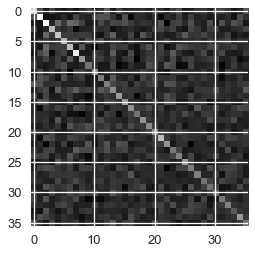

In [38]:
# P are PCA components
# Will use w2_pullback as part of the algorithm
w2_pullback = np.dot(P,np.dot(M_gml_sift,P.T))
plt.imshow(w2_pullback);

a) We pullback GML on PCA to GML on original space and look at KNN accuracy and error

** Horrible accuracy - but then again, why would the pullback be a good indicator of the true GML**

In [39]:
# Transform into histogram since LMNN is non-normalized
# Wasserstein needs normalized data
#[X_train_normalized, X_test_normalized] = mml.transform.normalize(X_train,X_test,'l1')

# K Nearest Neighbour with predefined metric
# model_wasserstein = KNeighborsClassifier(n_neighbors=k,metric='pyfunc')
acc_wasserstein_pullback = []
errors_wasserstein_pullback = []
        
for k in K1:    
    model_l2_wasserstein = KNeighborsClassifier(n_neighbors=k,metric=mml.wasserstein.distance,\
                                                  metric_params={"ground metric":w2_pullback})
    model_l2_wasserstein.fit(X_train_normalized,Y_train)
    
    score_w = model_l2_wasserstein.score(X_test_normalized,Y_test)
    prediction = model_l2_wasserstein.predict_proba(X_test_normalized)
    
    error = log_loss(Y_test,prediction)
    print("k=%d, accuracy=%.2f%%" % (k, score_w * 100))
    acc_wasserstein_pullback.append(score_w)
    errors_wasserstein_pullback.append(error)


j = np.argmax(acc_wasserstein_pullback)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K1[j],
acc_wasserstein_pullback[j] * 100))

k=1, accuracy=10.61%
k=3, accuracy=10.61%
k=5, accuracy=10.61%
k=1 achieved highest accuracy of 10.61% on test data


b) We pullback GML on PCA to original space and initialize learning GML with pullback. 
   Repeat step 4 afterwards to find and compare KNN accuracy and error as well as time taken to learn. 
   
   All experiments related to learning GML run on buck.inf.ed.ac.uk which has a Titan X (but regular Wasserstein doesn't work on Titan X) 

____

### Ignore below here: 
VAE Space - this will go into each analysis separately.


#### 7. L2 KNN with VAE LMNN

In [49]:
# Apply LMNN to PCA data
init_vae = np.eye(25,25)
[X_train_vae_lmnn, X_test_vae_lmnn, lmnn_vae] = train_lmnn(X_train_vae_normalized,X_test_vae_normalized,Y_train_vae,init_vae)

In [50]:
accuracies_vae_lmnn = []
errors_vae_lmnn =[]
for k in K: 
    # build a model
    model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
    model.fit(X_train_vae_lmnn,Y_train_vae)
    
    # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
    score = model.score(X_test_vae_lmnn, Y_test_vae)
    prediction = model.predict_proba(X_test_vae_lmnn)
    #error = getXEntropySoftmaxError(prediction, Y_test)
    error= log_loss(Y_test_vae,prediction)
    
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies_vae_lmnn.append(score)
    errors_vae_lmnn.append(error)

i = np.argmax(accuracies_vae_lmnn)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K[i],
accuracies_vae_lmnn[i] * 100))

k=1, accuracy=83.60%
k=3, accuracy=82.80%
k=5, accuracy=84.80%
k=7, accuracy=84.80%
k=9, accuracy=84.00%
k=11, accuracy=84.80%
k=5 achieved highest accuracy of 84.80% on test data


#### 8. W2 KNN with VAE GML 

In [68]:
accuracies_vae_gml = []
errors_vae_gml =[]
for k in K: 
    # build a model
    model = KNeighborsClassifier(n_neighbors=k,metric=mml.wasserstein.distance,\
                                                 metric_params={"ground metric":M_gml_vae})

    model.fit(X_train_vae_normalized,Y_train_vae)
    
    # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
    score = model.score(X_test_vae_normalized, Y_test_vae)
    prediction = model.predict_proba(X_test_vae_normalized)
    #error = getXEntropySoftmaxError(prediction, Y_test)
    error= log_loss(Y_test_vae,prediction)
    
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies_vae_gml.append(score)
    errors_vae_gml.append(error)

i = np.argmax(accuracies_vae_gml)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K[i],
accuracies_vae_gml[i] * 100))

k=1, accuracy=81.60%
k=3, accuracy=79.20%
k=5, accuracy=81.60%
k=7, accuracy=80.00%
k=9, accuracy=80.40%
k=11, accuracy=79.60%
k=1 achieved highest accuracy of 81.60% on test data


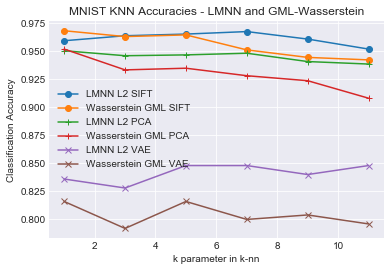

In [86]:
# Plot the accuracies in the same space
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

# Plot the accuracies in the same space
plt.title("MNIST KNN Accuracies - LMNN and GML-Wasserstein")
plt.xlabel("k parameter in k-nn")
plt.ylabel("Classification Accuracy")
# 1
plt.plot(K,accuracies_lmnn,marker='o',label="LMNN L2 SIFT")
# 2 
plt.plot(K,acc_wasserstein_l2,marker='o',label="Wasserstein GML SIFT")

# 3 
plt.plot(K,acc_pca_lmnn,marker ='+',label="LMNN L2 PCA")
# 4
plt.plot(K,acc_knn_pca_wasserstein,marker ='+',label="Wasserstein GML PCA")

# 5
plt.plot(K,accuracies_vae_lmnn,marker ='x',label="LMNN L2 VAE")
# 6
plt.plot(K,accuracies_vae_gml,marker ='x',label="Wasserstein GML VAE")


_=plt.legend()
plt.savefig("KNN_GML_Accuracies.png")

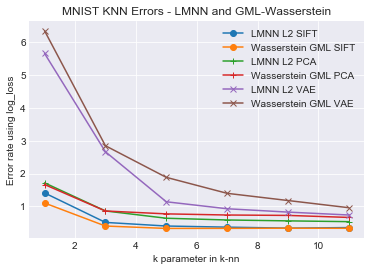

In [87]:
# Plot the accuracies in the same space
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

# Plot the accuracies in the same space
plt.title("MNIST KNN Errors - LMNN and GML-Wasserstein")
plt.xlabel("k parameter in k-nn")
plt.ylabel("Error rate using log_loss")


# 1
plt.plot(K,errors_lmnn,marker='o',label="LMNN L2 SIFT")
# 2 
plt.plot(K,errors_wasserstein_l2,marker='o',label="Wasserstein GML SIFT")

# 3 
plt.plot(K,errors_pca_lmnn,marker ='+',label="LMNN L2 PCA")
# 4
plt.plot(K,errors_knn_pca_wasserstein,marker ='+',label="Wasserstein GML PCA")

# 3 
plt.plot(K,errors_vae_lmnn,marker ='x',label="LMNN L2 VAE")
# 4
plt.plot(K,errors_vae_gml,marker ='x',label="Wasserstein GML VAE")


_=plt.legend()
plt.savefig("KNN_GML_Errors.png")

#### 5. Learn LMNN with pullback initializer then L2 KNN 
    * Achieves highest accuracy out of all of them, which is nice I guess

In [18]:
# Learn with 1000 iterations using the pullback as initializer
X_train_lmnn_pullback, X_test_lmnn_pullback, lmnn_pullback = train_lmnn(X_train,X_test,Y_train,
                                                                  pullback,steps=1000)

In [26]:
# Use the early stopping pullback i.e. LMNN on PCA is stopped early
X_train_lmnn_pullback_2, X_test_lmnn_pullback_2, lmnn_pullback_2 = train_lmnn(X_train, X_test, 
                                                                              Y_train,pullback_2)
X_train_lmnn_pullback_3, X_test_lmnn_pullback_3, lmnn_pullback_3 = train_lmnn(X_train, X_test, 
                                                                              Y_train,pullback_3)

In [19]:
accuracies_lmnn_pullback = []
errors_lmnn_pullback =[]
for k in K: 
    # build a model
    model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
    model.fit(X_train_lmnn_pullback,Y_train)
    
    # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
    score = model.score(X_test_lmnn_pullback, Y_test)
    prediction = model.predict_proba(X_test_lmnn_pullback)
    #error = getXEntropySoftmaxError(prediction, Y_test)
    error= log_loss(Y_test,prediction)
    
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies_lmnn_pullback.append(score)
    errors_lmnn_pullback.append(error)

i = np.argmax(accuracies_lmnn_pullback)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K[i],
accuracies_lmnn_pullback[i] * 100))

k=1, accuracy=99.44%
k=3, accuracy=99.44%
k=5, accuracy=99.17%
k=7, accuracy=99.17%
k=9, accuracy=98.89%
k=11, accuracy=98.61%
k=1 achieved highest accuracy of 99.44% on test data


In [39]:
accuracies_lmnn_pullback_2 = []
errors_lmnn_pullback_2 =[]
for k in K: 
    # build a model
    model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
    model.fit(X_train_lmnn_pullback_2,Y_train)
    
    # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
    score = model.score(X_test_lmnn_pullback_2, Y_test)
    prediction = model.predict_proba(X_test_lmnn_pullback_2)
    #error = getXEntropySoftmaxError(prediction, Y_test)
    error= log_loss(Y_test,prediction)
    
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies_lmnn_pullback_2.append(score)
    errors_lmnn_pullback_2.append(error)

i = np.argmax(accuracies_lmnn_pullback_2)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K[i],
accuracies_lmnn_pullback_2[i] * 100))

k=1, accuracy=99.44%
k=3, accuracy=99.44%
k=5, accuracy=99.17%
k=7, accuracy=99.17%
k=9, accuracy=98.89%
k=11, accuracy=98.61%
k=1 achieved highest accuracy of 99.44% on test data


In [40]:
accuracies_lmnn_pullback_3 = []
errors_lmnn_pullback_3 =[]
for k in K: 
    # build a model
    model = KNeighborsClassifier(n_neighbors=k,metric="euclidean")
    model.fit(X_train_lmnn_pullback_3,Y_train)
    
    # evaluate and print accuracies and xEntropy Softmax error (for multiclass predictions)
    score = model.score(X_test_lmnn_pullback_3, Y_test)
    prediction = model.predict_proba(X_test_lmnn_pullback_3)
    #error = getXEntropySoftmaxError(prediction, Y_test)
    error= log_loss(Y_test,prediction)
    
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies_lmnn_pullback_3.append(score)
    errors_lmnn_pullback_3.append(error)

i = np.argmax(accuracies_lmnn_pullback_3)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K[i],
accuracies_lmnn_pullback_3[i] * 100))

k=1, accuracy=99.17%
k=3, accuracy=98.89%
k=5, accuracy=98.89%
k=7, accuracy=98.61%
k=9, accuracy=98.61%
k=11, accuracy=98.61%
k=1 achieved highest accuracy of 99.17% on test data


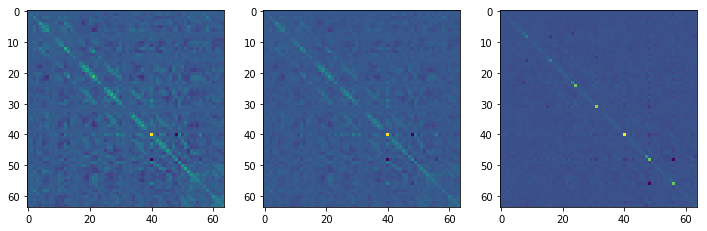

In [41]:
# LMNN after using the pullback metric as the initializer
fig, ax = plt.subplots(1,3, figsize=(12,12))

L_pullback = lmnn_pullback.get_linear_transform()
M_pullback_upper = np.dot(L_pullback, L_pullback.T)
ax[0].imshow(M_pullback_upper);

L_pullback_2 = lmnn_pullback_2.get_linear_transform()
M_pullback_upper_2 = np.dot(L_pullback_2, L_pullback_2.T)
ax[1].imshow(M_pullback_upper_2);

L_pullback_3 = lmnn_pullback_3.get_linear_transform()
M_pullback_upper_3 = np.dot(L_pullback_3, L_pullback_3.T)
ax[2].imshow(M_pullback_upper_3);

In [42]:
# Observe how 1000 iterations and 500 iterations are super close. 
# 100 iterations is almost not visible
diff =  L_upper - L_pullback
print(np.sum(diff))

6.78556589744


In [222]:
hist_zero = np.histogram(X_train[9])
hist_four = np.histogram(X_train[5])

In [ ]:
ax = ax = sns.heatmap(X_train[9].reshape(-8,8))
pylab.savefig("zero")

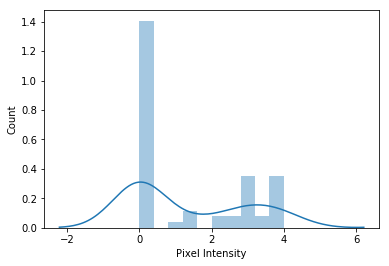

In [244]:
ax = sns.distplot(X_train[5],bins=10,norm_hist=True)
ax.set_xlabel("Pixel Intensity")
ax.set_ylabel("Count");
pylab.savefig("four_hist")

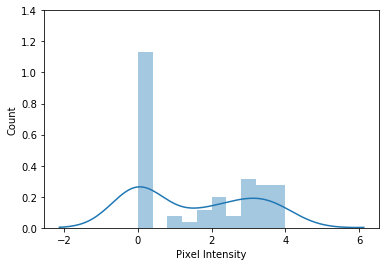

In [246]:
ax = sns.distplot(X_train[9],bins=10,norm_hist=True)
ax.set_xlabel("Pixel Intensity")
ax.set_ylabel("Count");
ax.set_ylim(top=1.4)
pylab.savefig("zero_hist")

In [216]:
bins_hist = np.arange(10,dtype=np.float64).reshape((10,1))
# By default metric ='sqeuclidean' in the function
M_hist = ot.dist(bins_hist,bins_hist,metric='euclidean')

In [233]:

hist_zero_normalized = hist_zero[0]/hist_zero[0].sum()
hist_four_normalized = hist_four[0]/hist_four[0].sum()

In [234]:
[wc,m] = mml.wasserstein.coupling(hist_zero_normalized,
                              hist_four_normalized,
                              **{"ground metric":M_hist})

In [ ]:
[wc,m] = mml.wasserstein.coupling(X_train_normalized[5],
                              X_train_normalized[9],
                              **{"ground metric":M_original})

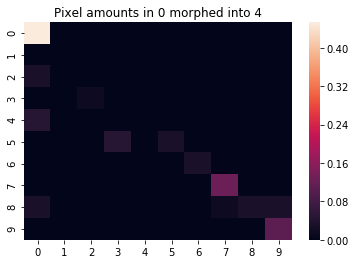

In [242]:
ax = sns.heatmap(wc)
ax.set_title("Pixel amounts in 0 morphed into 4")
pylab.savefig("Wasserstein_coupling")

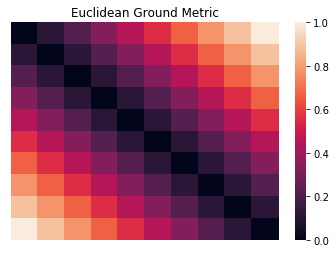

In [243]:
import seaborn as sns
import matplotlib.pylab as pylab

ax = sns.heatmap(M_hist,xticklabels="",yticklabels="")
ax.set_title("Euclidean Ground Metric")
pylab.savefig("Euclidean_Metric")

#### Ground-ification of the metric  

In [66]:
#d_pullback_euclidean1 = np.zeros((36,36))
d_pullback_euclidean2 = np.zeros((25,25))
#e = np.eye(64)

# Pullback euclidean metric through given L ...
# def pullback(L_original):
for i in range(0,25):
    for j in range(0,25):
        #d_pullback_euclidean1[i][j] = np.linalg.norm(M_gml_pca[i] -  M_gml_pca[j])
        d_pullback_euclidean2[i][j] = np.linalg.norm(M_gml_vae[i] - M_gml_vae[j])

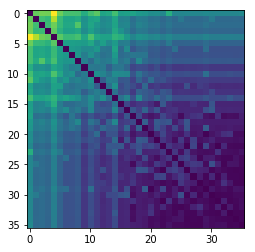

In [64]:
plt.imshow(M_gml_pca)

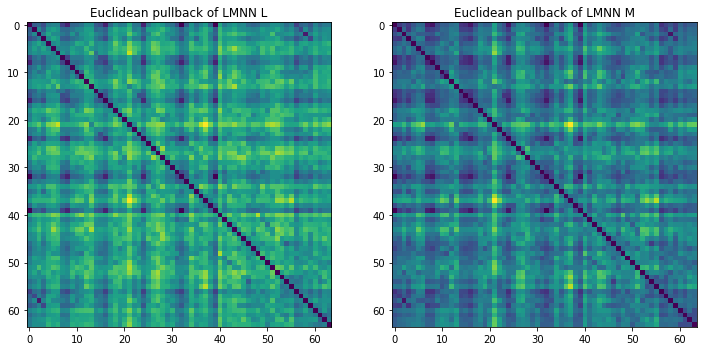

In [103]:
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(d_pullback_euclidean1)
ax[0].set_title("Euclidean pullback of LMNN L")
ax[1].imshow(d_pullback_euclidean2)
ax[1].set_title("Euclidean pullback of LMNN M");

#phi_x = np.dot(d_patric,x1)
#M_LMNN = ot.dist(phi_x,phi_x,metric='euclidean')
#M_LMNN.shape
#plt.imshow(M_LMNN)

#### 6. LMNN using L2 pullback as initializer then W2-KNN
    * Only $W_2$ for now 
    * Does it make sense?
    * takes ages..get 99 % 

In [104]:
K1 = [1,3]
errors_pullback_wasserstein = []
acc_pullback_wasserstein = []

        
for k in K1:    
    m = KNeighborsClassifier(n_neighbors=k,metric=mml.wasserstein.distance,\
                                                  metric_params={"ground metric":d_pullback_euclidean1})
    m.fit(X_train_normalized,Y_train)
     
    score = m.score(X_test_normalized,Y_test)
    prediction = m.predict_proba(X_test_normalized)
    
    #error = getXEntropySoftmaxError(prediction_proba, Y_test)
    error = log_loss(Y_test,prediction)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    acc_pullback_wasserstein.append(score)
    errors_pullback_wasserstein.append(error)

j = np.argmax(acc_pullback_wasserstein)
print("k=%d achieved highest accuracy of %.2f%% on test data" % (K[j],
acc_pullback_wasserstein[j] * 100))

k=1, accuracy=99.17%
k=3, accuracy=97.78%
k=1 achieved highest accuracy of 99.17% on test data


#### Accuracies and errors
* TODO: add AUC-ROC

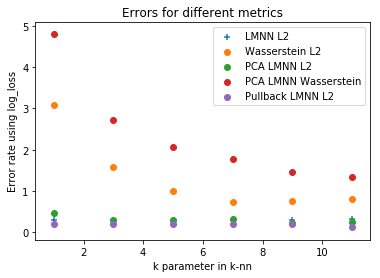

In [110]:
# Plot the errors in the same space
# Interestingly, the pullback LMNN does the best out of all of them
plt.title("Errors for different metrics")
plt.xlabel("k parameter in k-nn")
plt.ylabel("Error rate using log_loss")
# 1
plt.scatter(K,errors_lmnn,marker='+',label="LMNN L2")
# 2 
plt.scatter(K,errors_wasserstein_l2,label="Wasserstein L2")
# 3
plt.scatter(K,errors_pca_lmnn,label="PCA LMNN L2")
# 4
plt.scatter(K,errors_knn_pca_wasserstein,label="PCA LMNN Wasserstein")
# 5
plt.scatter(K,errors_lmnn_pullback,label="Pullback LMNN L2")

_=plt.legend()

#### PCA 
**Important question: Do we really need to standardize? I should try both approaches**

* Use PCA to learn a (linear) embedding of the original space. 
* Compute LMNN on the reduced space and do KNN with L_2 and W_2
* Do a pullback of the metric learned (GML- Cuturi) from reduced space to original space
* Use the pullback as an initializer for LMNN and GML on the original space 
Also 
* Think about Lebanon and Riemannian metric learning

**Miscelaneouss - previous ideas**:
- Step 1: do PCA on X_train. Then do LMNN on that, then do Wasserstein on that and KNN based on G_Wasserstein
- Step 2: do Wasserstein on the initial LMNN and then KNN. 


In [12]:
# Transform the data using 95% of variance. 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

pca = PCA(n_components=38)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Sanity check for PCA - connecting the dots to LMNN
#P = pca.components_
#I = np.dot(P,P.T)
#plt.imshow(I)
#Constraint is M = I
#print(I.diagonal().sum())
#print(I.shape)

In [13]:
# Apply LMNN to PCA data
init_t = np.eye(38,38)
[X_train_pca_lmnn, X_test_pca_lmnn, lmnn_pca] = train_lmnn(X_train_pca,X_test_pca,Y_train,init_t)

#### Find LMNN metric using early stopping and pullback that one to bigger space

In [22]:
# Apply LMNN to PCA data
init_t = np.eye(38,38)
[X_train_pca_lmnn_2, X_test_pca_lmnn_2, lmnn_pca_2] = train_lmnn(X_train_pca,X_test_pca,
                                                                 Y_train,init_t,steps=500)
[X_train_pca_lmnn_3, X_test_pca_lmnn_3, lmnn_pca_3] = train_lmnn(X_train_pca,X_test_pca,
                                                                 Y_train,init_t,steps=100)

#### Plot and calculate the LMNN metric on the PCA space

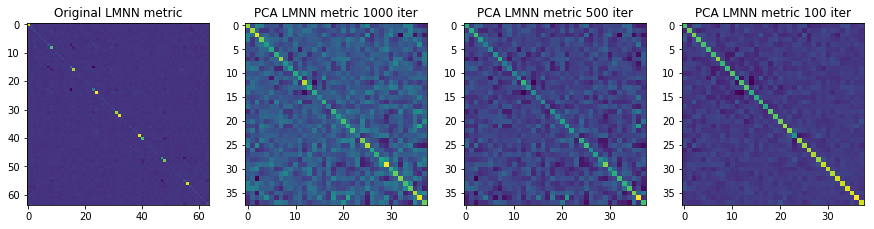

In [24]:
# LMNN Upper metric
L_upper = lmnn.get_linear_transform()
M_upper = np.dot(L_upper,L_upper.T)

# PCA LMNN metric
L_pca = lmnn_pca.get_linear_transform()
M_pca = np.dot(L_pca,L_pca.T)

# PCA LMNN metric 2 and 3
L_pca_2 = lmnn_pca_2.get_linear_transform()
L_pca_3 = lmnn_pca_3.get_linear_transform()

M_pca_2 = np.dot(L_pca_2,L_pca_2.T)
M_pca_3 = np.dot(L_pca_3,L_pca_3.T)

fig, ax = plt.subplots(1,4, figsize=(15,12))
ax[0].imshow(M_upper)
ax[0].set_title("Original LMNN metric")
ax[1].imshow(M_pca)
ax[1].set_title("PCA LMNN metric 1000 iter")
ax[2].imshow(M_pca_2)
ax[2].set_title("PCA LMNN metric 500 iter")
ax[3].imshow(M_pca_3)
ax[3].set_title("PCA LMNN metric 100 iter")
plt.show()

Pullback of PCA metric through the inverse transformation to reach the dimension of the upper metric



In [25]:
P = pca.components_

# Use pullback for now
pullback = np.dot(P.T,np.dot(L_pca,P))
pullback_metric = np.dot(P.T,np.dot(M_pca,P))

pullback_2 = np.dot(P.T,np.dot(L_pca_2,P))
pullback_3 = np.dot(P.T,np.dot(L_pca_3,P))

#eigenvector_matrix.T * metric_pca * eigenvector_matrix

# VINCENT 
#pb(x1,x2) = lmnn_pca(f(x1),f(x2))
# Formula1 weinberger
#pb(x1,x2) = (L_pca * (P*x1 - P*x2))**2

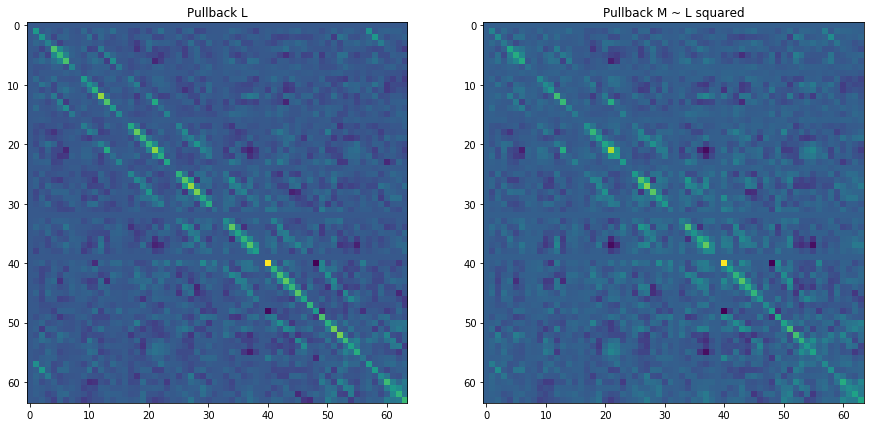

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,12))
ax[0].imshow(pullback)
ax[0].set_title("Pullback L")
ax[1].imshow(pullback_metric)
ax[1].set_title("Pullback M ~ L squared");

Below is not complete

In [34]:
mml.ot_testing.is_metric(np.asarray(pullback_metric))

True

______________________________

## Miscellaneous

In [271]:
# Below is for data reconstruction, we don't really need that. 
rows = X_train_pca_lmnn.shape[0]
col = X_train.shape[1]
reconstructed_data = np.zeros((rows,col))
for i in range(rows):
    reconstructed_data[i] = pca.mean_ + X_train_pca_lmnn[i].dot(pca.components_)

In [272]:
rows_test = X_test_pca_lmnn.shape[0]
col_test = X_test.shape[1]
reconstructed_test_data = np.zeros((rows_test,col_test))
for i in range(rows_test):
    reconstructed_test_data[i] = pca.mean_ + X_test_pca_lmnn[i].dot(pca.components_)

_____________________________________________________________________
**Below is educational purposes, courtesy of IAML and not important**

In [ ]:
# Standardize the data and apply PCA on Hellinger representation of the digits 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

pca = PCA(n_components = X_train_std.shape[1])
pca.fit(X_train_std)
plt.figure()
plt.plot(np.arange(1,pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
n_eigenvectors_95pc = np.argmax(np.cumsum(pca.explained_variance_ratio_) > .95) + 1
max_variance = np.max(pca.explained_variance_ratio_)
plt.vlines(x = n_eigenvectors_95pc, ymin=0, ymax=max_variance, linestyle='--')
plt.annotate('95% variance explained\nby {} eigenvectors'.format(n_eigenvectors_95pc), 
             xy=(n_eigenvectors_95pc, pca.explained_variance_ratio_[n_eigenvectors_95pc]), 
             xytext=(n_eigenvectors_95pc+10, pca.explained_variance_ratio_[n_eigenvectors_95pc]+.05),
             arrowprops=dict(facecolor='black', shrink=0.05),)
plt.margins(0.1, tight=True)
plt.show()


In [ ]:
idx = 1
fig, ax = plt.subplots(1,5, figsize=(20,12))

# Can change from X_train_std to X_train if you don't want the scaled version
sns.heatmap(X_train_std[idx].reshape((8,8)), square=True, ax=ax[0], cbar=False,
            annot=True, fmt='0.1f')
ax[0].set_title('Scaled original img')

# Only transform one digit and use different number of eigenvectors to reconstruct. 
img_pca = pca.transform(X_train_std[idx,:].reshape(1, -1)).flatten()
pca_coefs = np.zeros(64)
pc_list = [5,29,38,64]
for ii, nr_pcs in enumerate(pc_list):
    ii += 1
    
    # Choose number of eigen-components to reconstruct. 
    pca_coefs[:nr_pcs] = img_pca[:nr_pcs]
    img = (pca.mean_ + pca_coefs.dot(pca.components_)).reshape((8,8))
    
    # Display the other reconstructions
    sns.heatmap(img, square=True, ax=ax[ii], cbar=False,
                annot=True, fmt='0.1f')
    coefs = np.around(img_pca[:nr_pcs]).astype(int)
    explained_var = int(np.round(np.sum(pca.explained_variance_ratio_[:nr_pcs]), 2)*100)
    ax[ii].set_title('Reconstruction with {} PCs\n{}% variance explained'.\
                     format(nr_pcs, explained_var))
plt.tight_layout()

plt.show()



In [ ]:
# Mahalanobis is a valid metric - but it's not zero on the diagonal!! on the contrary! 
mahalanobis = np.dot(l_transform.T,l_transform)
test_is_metric(mahalanobis)
from metric_learn import Covariance
from sklearn.datasets import load_iris

iris = load_iris()['data']

cov = Covariance().fit(iris)
dummy_X = cov.transform(iris)

#plt.imshow(digits.images[1]);
#x_1 = X_test_lmnn[1].reshape(8,8)
plt.imshow(np.sqrt(digits.images[0]));

# how many 0s do we have? plenty
count = 0
for target in digits.target:
    if target ==1:
        count += 1
print(count)        

def getXEntropySoftmaxError(outputs,targets):
    probs = np.exp(outputs)
    probs /= probs.sum(-1)[:, None]
    return -np.mean(np.sum(targets * np.log(probs), axis=1))